Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain
gr(size=(500,500));

┌ Info: Recompiling stale cache file /Users/rob/.julia/compiled/v1.1/StanMCMCChain/HWPbY.ji for StanMCMCChain [8f1571ae-b3a1-52af-8ab1-32258739efdb]
└ @ Base loading.jl:1184


CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "02")
cd(ProjDir)

Define the Stan language model

In [3]:
binomialstanmodel = "
// Inferring a Rate
data {
  int N;
  int<lower=0> k[N];
  int<lower=1> n[N];
}
parameters {
  real<lower=0,upper=1> theta;
  real<lower=0,upper=1> thetaprior;
}
model {
  // Prior Distribution for Rate Theta
  theta ~ beta(1, 1);
  thetaprior ~ beta(1, 1);

  // Observed Counts
  k ~ binomial(n, theta);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [4]:
stanmodel = Stanmodel(name="binomial", monitors = ["theta"], model=binomialstanmodel,
  output_format=:mcmcchain);
# Use 16 observations
N2 = 15
d = Binomial(9, 0.66)
n2 = Int.(9 * ones(Int, N2));


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/02/tmp/binomial.stan will be updated.



Show first 5 (generated) observations

In [5]:
k2 = rand(d, N2);
k2[1:min(5, N2)]

5-element Array{Int64,1}:
 5
 7
 7
 4
 7

Input data for cmdstan

In [6]:
binomialdata = Dict("N" => length(n2), "n" => n2, "k" => k2);

Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, binomialdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)


Inference for Stan model: binomial_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.028, 0.026, 0.027, 0.026) seconds, 0.11 seconds total
Sampling took (0.043, 0.040, 0.036, 0.042) seconds, 0.16 seconds total

                Mean     MCSE  StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__             -93  2.7e-02     1.1    -96   -93   -92  1.8e+03  1.1e+04  1.0e+00
accept_stat__   0.90  2.0e-03    0.13   0.61  0.95   1.0  4.5e+03  2.8e+04  1.0e+00
stepsize__      0.89  4.9e-02   0.070   0.78  0.95  0.95  2.0e+00  1.2e+01  4.1e+13
treedepth__      1.9  7.7e-02    0.59    1.0   2.0   3.0  5.9e+01  3.6e+02  1.0e+00
n_leapfrog__     4.0  4.8e-01     3.4    1.0   3.0    11  4.9e+01  3.0e+02  1.0e+00
divergent__     0.00      nan    0.00   0.00  0.00  0.00      nan      nan      nan
energy__          94  3.8e-02     1.5     93    94    97  1.6e+03  9.7e+03  1.0e+00
theta           0.62  7.1e-04   0.042  

Allocate array of Normal fits

In [8]:
fits = Vector{Normal{Float64}}(undef, 4)
for i in 1:4
  fits[i] = fit_mle(Normal, convert.(Float64, chn.value[:, 1, i]))
  println(fits[i])
end

Normal{Float64}(μ=0.619386497, σ=0.04146275356553146)
Normal{Float64}(μ=0.620276690000001, σ=0.044383374441967535)
Normal{Float64}(μ=0.6210198049999998, σ=0.04187588941189159)
Normal{Float64}(μ=0.619793153, σ=0.04134528018738765)


Plot the 4 chains

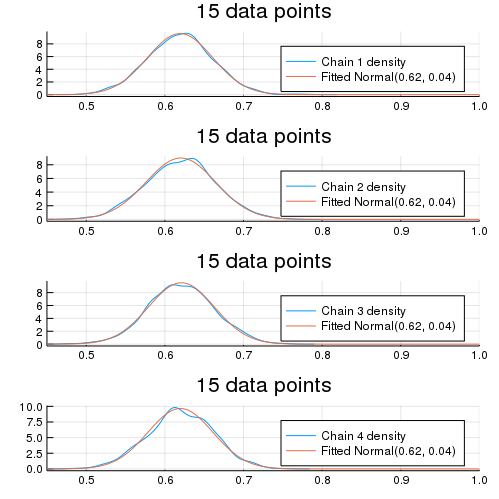

In [9]:
mu_avg = sum([fits[i].μ for i in 1:4]) / 4.0;
sigma_avg = sum([fits[i].σ for i in 1:4]) / 4.0;

if rc == 0
  p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
  x = 0:0.001:1
  for i in 1:4
    vals = convert.(Float64, chn.value[:, 1, i])
    μ = round(fits[i].μ, digits=2)
    σ = round(fits[i].σ, digits=2)
    p[i] = density(vals, lab="Chain $i density",
       xlim=(0.45, 1.0), title="$(N2) data points")
    plot!(p[i], x, pdf.(Normal(fits[i].μ, fits[i].σ), x), lab="Fitted Normal($μ, $σ)")
  end
  plot(p..., layout=(4, 1))
end

Compute at hpd region

In [10]:
bnds = MCMCChain.hpd(chn[:, 1, :], alpha=0.055);

Show hpd region

In [11]:
println("hpd bounds = $bnds\n")

hpd bounds =       94.5% Lower 94.5% Upper
theta    0.542158    0.705808





quadratic approximation

Compute MAP, compare with CmndStan & MLE

In [12]:
tmp = convert(Array{Float64,3}, chn.value)
draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)

4000-element Array{Float64,1}:
 0.640372
 0.632455
 0.655338
 0.609389
 0.604053
 0.608778
 0.621112
 0.620722
 0.631762
 0.639473
 ⋮       
 0.713468
 0.596692
 0.614448
 0.644459
 0.678275
 0.598771
 0.598442
 0.632704
 0.620169

Compute MAP

In [13]:
using Optim

x0 = [0.5]
lower = [0.2]
upper = [1.0]

inner_optimizer = GradientDescent()

function loglik(x)
  ll = 0.0
  ll += log.(pdf.(Beta(1, 1), x[1]))
  ll += sum(log.(pdf.(Binomial(9, x[1]), k2)))
  -ll
end

res = optimize(loglik, lower, upper, x0, Fminbox(inner_optimizer))

Results of Optimization Algorithm
 * Algorithm: Fminbox with Gradient Descent
 * Starting Point: [0.5]
 * Minimizer: [0.6222222222035033]
 * Minimum: 2.622812e+01
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 6.00e-09 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 4.06e-16 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 3.22e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 60
 * Gradient Calls: 60

Summarize mean and sd estimates

CmdStan mean and sd:

In [14]:
[mean(chn.value), std(chn.value)]

2-element Array{Float64,1}:
 0.6201190362500002 
 0.04229460383461249

MAP estimate and associated sd:

In [15]:
[Optim.minimizer(res)[1], std(draws, mean=mean(chn.value))]

2-element Array{Float64,1}:
 0.6222222222035033 
 0.04229460383461249

MLE of mean and sd:

In [16]:
[mu_avg, sigma_avg]

2-element Array{Float64,1}:
 0.6201190362500002 
 0.04226682440169456

Turing Chain &  89% hpd region boundaries

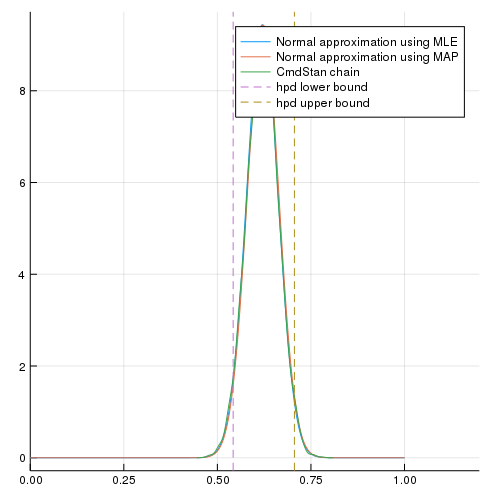

In [17]:
plot( x, pdf.(Normal( mu_avg , sigma_avg  ) , x ),
xlim=(0.0, 1.2), lab="Normal approximation using MLE")
plot!( x, pdf.(Normal( Optim.minimizer(res)[1] , std(draws, mean=mean(chn.value))) , x),
lab="Normal approximation using MAP")
density!(draws, lab="CmdStan chain")
vline!([bnds.value[1]], line=:dash, lab="hpd lower bound")
vline!([bnds.value[2]], line=:dash, lab="hpd upper bound")

End of `clip_08s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*